#### 0.1 Installing and loading modules

In [1]:
#!pip install pmdarima
#!pip install TBATS
#!pip install auto_ts
#pip install fedot==0.3.0
# !pip install auto_ts

#### 0.2 Importing modules

In [1]:
import os
import pandas as pd; pd.set_option('display.max_columns', None) 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pickle
from IPython.display import clear_output as co
from random import random
import warnings; # ...

import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn.utils

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima.arima import auto_arima
from tbats import TBATS
# import auto_ts
# import prophet
#from fedot.api.main import Fedot

import tools # custom module

#### 0.3 Defining accuracy metrics

In [2]:
le = sklearn.preprocessing.LabelEncoder
metrics = sklearn.metrics._regression
mae = metrics.mean_absolute_error
mse = metrics.mean_squared_error
mape = metrics.mean_absolute_percentage_error
r2 = metrics.r2_score
me = metrics.max_error
medae = metrics.median_absolute_error
evs = metrics.explained_variance_score
mpd = metrics.mean_poisson_deviance
mgd = metrics.mean_gamma_deviance
def wape(ye, yhat):
    return np.abs(ye-yhat).sum()/ye.sum()
def e(ye, yhat):
    return np.abs(yhat-ye).sum()
def estd(ye, yhat):
    return np.abs(yhat-ye).std()

### 0.4 Defining scoring functions

In [68]:
## Evaluating model predictions given scorer list
def score_predictions_fancy(y_e, y_hat, model_name='', scorers=None, names=None):
    if type(scorers)==type(None):
        scorers = [mae, mse, mape, wape, r2]; names=scrs
    scores = [scorer(y_e, y_hat) for scorer in scorers]
    return pd.Series(scores, name=model_name, index=names)

## Evaluating model predictions given scorer list
def score_predictions_custom(y_e, y_hat, scorers=None):
    if type(scorers)==type(None):
        scorers = [mae, mse, mape, wape, r2]; names=['mae', 'mse', 'mape', 'wape', 'r2']
    return [scorer(y_e, y_hat) for scorer in scorers]

def score_by_product(Y_e, Y_hat, indexes, model_name, key='product_type', scorers=None, scorers_names=['mae', 'mse', 'mape', 'wape', 'r2']):
    prod_scrs = []
    for product in indexes.keys():
        prod_index = indexes[product]
        test_index = set(prod_index).intersection(Y_e.index)
        prod_scrs.append([ product ] + score_predictions_custom(Y_e.loc[test_index], Y_hat.loc[test_index], scorers=scorers))
    prod_scrs = pd.DataFrame(prod_scrs, columns=[key]+scorers_names)
    return prod_scrs

def score_model_predictions(Y_hat, Y_e, indexes, model_name, by='product_type', scorers=None, scorers_names=['mae', 'mse', 'mape', 'wape', 'r2']):
    model_scrs = pd.Series(score_predictions_custom(Y_e, Y_hat, scorers=scorers), index=scorers_names).to_frame().rename(columns={0: model_name}).T;
    prod_scrs = score_by_product(Y_e, Y_hat, indexes, model_name, key=by, scorers=scorers, scorers_names=scorers_names)
    return model_scrs, prod_scrs

def series_test_data(series, keys, target, target_years, year_col='year', include_missing=True):
    x_test = []
    for year in target_years:
        for key in keys:
            df = series[key].copy()
            if year in df[year_col].values:
                year_row = df.reset_index().set_index(year_col).loc[year]
                x_test.append(year_row.loc[['index', target]].values)
            else:
                if include_missing:
                    x_test.append(np.array([np.nan, np.nan]))
    return pd.DataFrame(x_test, columns=['Index', target]).set_index('Index')[target]

---

# 1. Preprocessing data

### 1.1 Loading data

In [4]:
target = 'area'
target_years = ['01/01/2016', '01/01/2017']
prodtypes = ['permanent', 'temporary', 'pasture']
prods = [
    'Rice', 'Beans', 'Cassava',
    'Corn', 'Soy', 'Sorghum',
    'Cocoa', 'Palm oil', 'Açaí',
    'Livestock', 'Others-temporary', 'Others-permanent'
]

In [5]:
data = pd.read_csv('data/historical-database-clean.csv')
X = pd.read_csv('data/series.csv', index_col=0)
series = tools.preprocess.load_series(path='data/series clean/')
keys = list(series.keys())
# raw_series = tools.preprocess.load_series(path='data/series/')
# X_full = pd.read_csv('data/raw_series.csv', index_col=0)

Done! Loaded 1107 files.


### 1.2 Processing data

In [6]:
X_train = X.loc[range(42)].copy()
X_test = X.loc[[42, 43]].copy()

In [7]:
x_test = series_test_data(series, keys, target, target_years, include_missing=True)
x_train = X_train.fillna(0).iloc[14:].copy()
# x_train = X.copy(); x_train.index = pd.DatetimeIndex(np.array([str(year) for year in range(1974, 2018)], dtype='datetime64[Y]'))

In [8]:
#### Extracting test data (2016 and 2017)
Y_e = tools.preprocess().test_data(series, data, keys=keys)
data_e = data.loc[Y_e.index].copy()
#### Extracting test index for each category in product_type-product combinations
prod_indexes = tools.category_index.get_ctgr_combs_indexes(data_e, prods)
#### Extracting test index for each category in product_type
prodtype_indexes = tools.category_index.get_ctgrs_indexes(data_e)

In [9]:
#### Setting label encoded index
LE = le().fit(data['year'])
lab_series = {}
for key in keys: lab_series[key] = series[key].set_index(LE.transform(series[key]['year']))[target].copy()

#### Train test split for label indexed series
tt_lab_series = {}
for key in keys:
    msk = lab_series[key].index.isin([42, 43])
    tt_lab_series[key] = {'train': lab_series[key][msk==False].copy(), 'test': lab_series[key][msk].copy()}

tt_lab_series[keys[0]]['train']

41    55.0
Name: area, dtype: float64

---
# 2. MULTIVARIATE TIME SERIES MODELING AND FORECASTING WITH SPECIALIZED MODELS

#### 2.0.1 Metric criterias settings

In [10]:
criteria_map = {'e': 0, 'estd': 0, 'max_error': 0, 'mae': 0, 'mse': 0, 'medae': 0, 'mape': 0, 'wape': 0, 'r2': -1, 'evs': -1}
scorers_names = ['e','estd','max_error','mae','mse','medae','mape','wape','r2','evs']
scorers = [e, estd, me, mae, mse, medae, mape, wape, r2, evs]
scrs = ['mae', 'mse', 'mape', 'wape', 'r2']
sel_scrs = scorers_names #scrs

#### 2.0.2 Sampling serie to test individual models

In [11]:
# contrived train and test datasets
train = tt_lab_series[keys[200]]['train'].copy()
test = tt_lab_series[keys[200]]['test'].copy()

## 2.1 AR (Auto regressive) example

In [14]:
def AutoReg_predict(train, lags=None, x_min=42, x_max=43):
    if len(train)<=3: return np.array([np.nan for i in range(2)])
    model = AutoReg(train, lags=lags)
    model_fit = model.fit()
    # make prediction
    return model_fit.predict(x_min, x_max)

def AutoReg_predict_series(tt_series, keys, lags=1):
    yhat = {}
    for key in keys:
        co(wait=True); print(f'{keys.index(key)}/{len(keys)}')
        testset = tt_series[key]['test']
        trainset = tt_series[key]['train']
        yhat[key] = AutoReg_predict(trainset.values, lags=lags, x_min=len(trainset), x_max=len(trainset)+1)
        for i, ind in zip([0, 1], [42, 43]):
            if ind not in testset.index:
                yhat[key][i] = np.nan
                
    return pd.DataFrame(yhat)

In [15]:
Yhat_AutoReg = AutoReg_predict_series(tt_lab_series, keys, lags=None)
# yhat = pd.Series(Yhat_AutoReg.values.reshape(-1), index=year_key_index).loc[x_test.index].fillna(0)
# scrs, prod_scrs = score_model_predictions(x_test, yhat, prodtype_indexes, model_name='AR', by='product_type')

1106/1107


## 2.2 ARIMA (Auto regressive moving average) example

In [16]:
def arima_predict(train, order=(1,1,1), x_min=42, x_max=43):
    if len(train)<=2: return np.array([np.nan for i in range(2)])
    # fit model
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    # make prediction
    return model_fit.predict(x_min, x_max)

def arima_predict_series(tt_series, keys, order=(1,1,1)):
    yhat_arima = {}
    for key in keys:
        co(wait=True); print(f'{keys.index(key)}/{len(keys)}')
        testset = tt_series[key]['test']
        trainset = tt_series[key]['train']
        yhat_arima[key] = arima_predict(trainset.values, order=order, x_min=len(trainset), x_max=len(trainset)+1)
        for i, ind in zip([0, 1], [42, 43]):
            if ind not in testset.index:
                yhat_arima[key][i] = np.nan
    
    return pd.DataFrame(yhat_arima, index=[42, 43])

In [17]:
Yhat_arima = arima_predict_series(tt_lab_series, keys, order=(1,1,1))

1106/1107


## 2.3 SARIMAX (Seasonal auto regressive moving average) example

In [18]:
# contrived train and test datasets
def predict_score_SARIMAX(series, key, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0), exog_train=None, exog_test=None):
    train = series[key]['train']
    test = series[key]['test']
    if len(train)<=2: return np.array([np.nan for i in range(2)])
    # fit model
    model = SARIMAX(train.values, exog=exog_train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    # make prediction
    yhat = model_fit.predict(len(train), len(train)+1, exog=exog_test)
    for i, ind in zip([0, 1], [42, 43]):
        if ind not in test.index:
            yhat[i] = np.nan
    return yhat

def predict_score_series_SARIMAX(series, keys):
    yhat = []
    for key in keys:
        co(wait=True); print(f'{keys.index(key)}/{len(keys)}')
        yhat_sarimax = predict_score_SARIMAX(tt_lab_series, key, order=(1, 1, 1), seasonal_order=(0,0,0,0))
        yhat.append(yhat_sarimax)
    yhat = pd.DataFrame(yhat).T; yhat.columns=keys
    return yhat

In [19]:
Yhat_sarimax = predict_score_series_SARIMAX(tt_lab_series, keys[:])

1106/1107


## 2.4 VAR (Vector auto regressive) example

In [20]:
def predict_VAR(X_train, steps=2, exog_train=None, exog_test=None):
    # fit model
    model = VAR(X_train, exog=exog_train)
    model_fit = model.fit()
    # make prediction
    lag_order = model_fit.k_ar
    yhat = model_fit.forecast(x_train.values[-lag_order:], steps=steps, exog_future=exog_test)
    # return dataframe
    return pd.DataFrame(yhat, columns=X_train.columns, index=range(len(X_train), len(X_train)+steps))

In [21]:
Yhat_var = predict_VAR(X_train.loc[14:].fillna(0), steps=2)

C:\Users\luisr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## 2.5 AutoArima (Automatic ARIMA) Example

In [22]:
def predict_series_auto_arima(series, keys, n_periods=2, train_min=3):
    Yhat, scores = [], []
    for key in keys:
        empty_pred = pd.Series([np.nan, np.nan], index=[42,43], name=key)
        try:
            co(wait=True); print(f'{keys.index(key)}/{len(keys)}')
            train = series[key]['train']
            test = series[key]['test']
            if len(train) <= train_min:
                Yhat.append(empty_pred)
                continue
            model = auto_arima(y=train, seasonal=False, stepwise=True)
            yhat = model.predict(n_periods=n_periods)
            for i, ind in zip([0, 1], [42, 43]):
                if ind not in test.index:
                    yhat[i] = np.nan
            Yhat.append(pd.Series(yhat, index=[42,43], name=key))

        except:
            Yhat.append(empty_pred)
            
#         scores.append(score_predictions_fancy(test, yhat, model_name=key))
    return pd.concat(Yhat, 1)#, pd.concat(scores, 1)

In [23]:
Yhat_autoarima =  predict_series_auto_arima(tt_lab_series, keys[:], train_min=3)

1106/1107


## 2.6 TBATS Example

In [24]:
def predict_tbats(train, steps):
    model_tbats = TBATS().fit(train)
    return model_tbats.forecast(steps=steps)

In [25]:
def predict_series_tbats(series, keys, steps=2):
    Yhat, scores = [], []
    for key in keys:
        co(wait=True); print(f'{keys.index(key)}/{len(keys)}')
        train = series[key]['train']
        test = series[key]['test']
        yhat = predict_tbats(train, steps=steps)
        Yhat.append(pd.Series(yhat, index=range(len(train), len(train)+steps), name=key))
        scores.append(score_predictions_fancy(test, yhat, model_name=key))
    return pd.concat(Yhat, 1), pd.concat(scores, 1)

In [ ]:
Yhat_tbats, scores = predict_series_tbats(tt_lab_series, keys[:], steps=2)

## 2.7 Save models predictions

#### 2.7.1 Format models' prediction table

In [98]:
model_names = ['Yhat_AutoReg', 'Yhat_arima', 'Yhat_sarimax', 'Yhat_var', 'Yhat_autoarima']#, 'Yhat_tbats']
model_predictions = [Yhat_AutoReg, Yhat_arima, Yhat_sarimax, Yhat_var, Yhat_autoarima]#, Yhat_tbats]

y_hat_i = pd.concat([pd.Series(model.values.reshape(-1), name=model_names[i]) for i, model in enumerate(model_predictions)], 1)
y_hat_i.index = keys*2
y_hat_i['year'] = ['01/01/2016']*len(keys) + ['01/01/2017']*len(keys)
y_hat_i = y_hat_i.reset_index(drop=False).rename(columns={'index': 'key'})

#### 2.7.2 Save models' prediction table as csv file

In [99]:
#y_hat_i.to_csv('evaluation/predictions/specialized_models_predictions_final.csv', index=True)

---
# 3. SCORE MODELS' PREDICTIONS

In [100]:
x_test = pd.Series(X_test.values.reshape(-1), index=y_hat_i.index).dropna()
models_scrs = []
for model in model_names:
    test_index = set(x_test.index).intersection(y_hat_i[model].index)
    models_scrs.append(score_predictions_fancy(x_test.loc[test_index], y_hat_i.loc[test_index][model].fillna(0), model_name=model))
models_scrs = pd.concat(models_scrs, 1)

In [101]:
models_scrs

,Yhat_AutoReg,Yhat_arima,Yhat_sarimax,Yhat_var,Yhat_autoarima
mae,7.588245e+03,1.181623e+03,1.181623e+03,1.567370e+03,1.239682e+03
mse,1.657427e+09,1.554773e+07,1.554773e+07,2.367336e+07,1.659776e+07
mape,1.071703e+16,2.933777e+15,2.933777e+15,1.137444e+16,2.822842e+15
wape,3.723125e-01,5.797558e-02,5.797558e-02,7.690203e-02,6.082423e-02
r2,7.860891e-01,9.979934e-01,9.979934e-01,9.969447e-01,9.978579e-01


---
## 4. VISUALIZE SELECTED MODEL PREDICTIONS vs REAL VALUES

In [95]:
def plot_preds(Yhat, keys, tt_lab_series, full_series=None, save=False, path=None, model_name=''):
    fig = plt.figure(figsize=(14, 10), tight_layout=True)
    n_rows = len(keys)//3 if len(keys)%3 == 0 else len(keys)//3+1
    axes = fig.subplots(n_rows,3)
    cnt = -1
    for axs in axes:
        for i in range(len(axs)):
            if cnt<len(keys)-1:
                ax = axs[i]
                cnt+=1; key=keys[cnt]
                train = tt_lab_series[key]['train']
                test = tt_lab_series[key]['test']
                yhat = Yhat[key].copy()
                if full_series is not None:
                    full_series[key].plot(ax=ax)
                else:
                    train.plot(ax=ax)
                test.plot(ax=ax, lw=2.5, marker='o', ms=4, label='True value')
                yhat.index=test.index
                yhat.plot(ax=ax, lw=2.5, marker='o', ms=4, label='Prediction')
                ax.set(ylabel='destinated area (acre)', xlabel='year', title=f'{model_name} prediction - {key}')
                
    if save:
        plt.savefig(path, tight_layout=True)
    plt.show()

def plot_sample_preds(Yhat, keys, tt_lab_series, n_samples=12, full_series=None, save=False, path='plots/sample_predictions.jpg', model_name=''):
    i = int(np.random.random(1)*(len(series)-n_samples-1))
    plot_preds(Yhat, keys[i:i+n_samples], tt_lab_series, full_series, save, path, model_name)

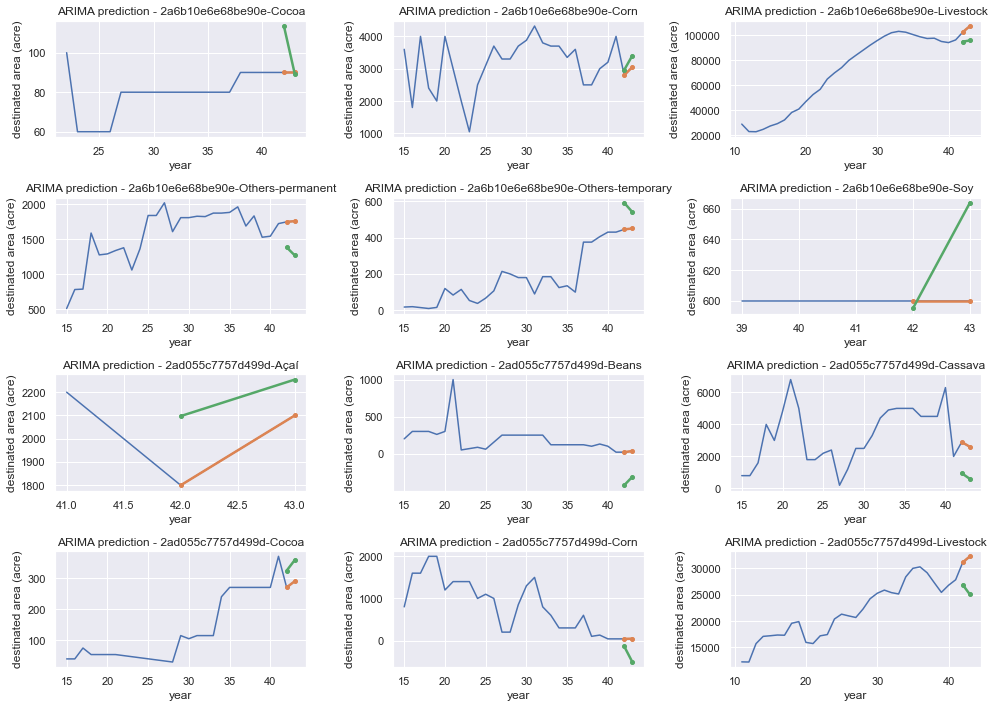

In [97]:
plot_sample_preds(
    Yhat_var, keys, tt_lab_series, n_samples=12,
    model_name='ARIMA', full_series=lab_series,
    save=True, path='plots/sample_arima_predictions.jpg'
)

---
# 5. EXTRA
### TESTING ADDITIONAL SPECIALIZED MODELS

### 5.1 VARMA example (NOT WORKING for all series  at once)

In [77]:
# fit model
def predict_VARMAX(X_train, steps=2, order=(1, 1)):
    model = VARMAX(X_train, order=order)
    model_fit = model.fit(disp=False)
    # make prediction
    return model_fit.forecast(steps=steps)

In [ ]:
Yhat_varma = predict_VARMAX(X_train.iloc[:, 0:10], steps=2)

### 5.2 VARMAX (with exogenous variables) example (NOT WORKING for all series  at once)

In [ ]:
# fit model
model = VARMAX(X_train.iloc[:, 1:5], exog=X_train.iloc[:, 6:10], order=(1, 1))
model_fit = model.fit(disp=False)
# make prediction
Yhat_varmax = model_fit.forecast(exog=X_test.iloc[:, 6:10], steps=2)